In [2]:
import sys
sys.path.append('../')

,image_name,label,path,train,label_id,image_id
0,n07720875_1.JPEG,bell pepper,images/bell pepper/n07720875_1.JPEG,True,0,0
1,n07720875_10.JPEG,bell pepper,images/bell pepper/n07720875_10.JPEG,True,0,1
2,n07720875_101.JPEG,bell pepper,images/bell pepper/n07720875_101.JPEG,True,0,2
3,n07720875_104.JPEG,bell pepper,images/bell pepper/n07720875_104.JPEG,True,0,3


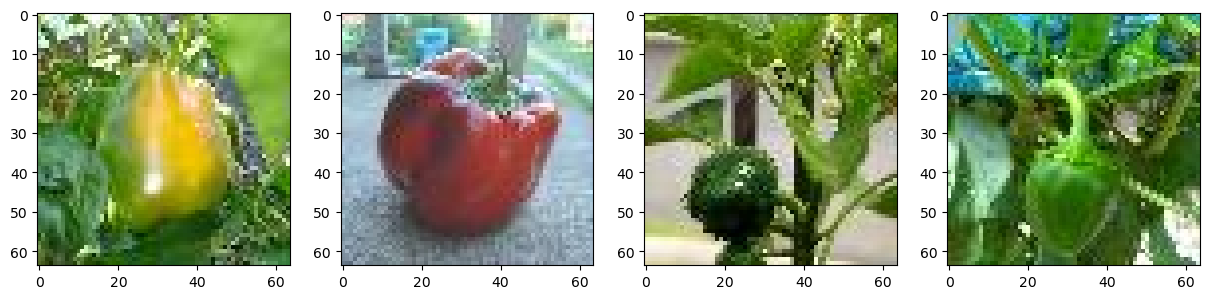

In [3]:
import cv2                      # Image Ops
import pandas as pd             # Other
import numpy as np              # Mat Opts
import matplotlib.pyplot as plt # Show Images

from utils.utils import load_images
from utils.features import load_features, save_features, extract_features
from utils.matching import minmin_retrival, match_all_images
from utils.scoring import calculate_metrics

from functools import partial

image_meta, images = load_images(True) # True - Train Images
display(image_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(images[0]);
ax[1].imshow(images[1]);
ax[2].imshow(images[2]);
ax[3].imshow(images[3]);

In [4]:
def orb_descriptor(image, wta = 4):
    orb = cv2.ORB_create(nfeatures = 50, scoreType = cv2.ORB_HARRIS_SCORE, WTA_K = wta)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, descs = orb.detectAndCompute(img, None)
    return descs

# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
descriptors, index = extract_features(orb_descriptor, images, min_features=-1, progress = True)
print("Tamaño de  descriptores:", descriptors.shape[1])
print("Número de  descriptores:", descriptors.shape[0])
print("Número Máximo de Descriptores Por Imágen :", pd.value_counts(index).max())
print("Número Medio  de Descriptores Por Imágen :", pd.value_counts(index).mean().round(0).astype(int))
print("Número Mínimo de Descriptores Por Imágen :", pd.value_counts(index).min())

# Obligatorio Siempre Guardar
save_features(descriptors, index, image_meta, "ORB")

  0%|          | 0/700 [00:00<?, ?it/s]

Tamaño de  descriptores: 32
Número de  descriptores: 128
Número Máximo de Descriptores Por Imágen : 1
Número Medio  de Descriptores Por Imágen : 1
Número Mínimo de Descriptores Por Imágen : 1


In [5]:
desc_meta, descriptors = load_features("../features/ORB.csv") # Siempre Cargar

,image_name,label,path,train,label_id,image_id
0,n07720875_0.JPEG,bell pepper,images/bell pepper/n07720875_0.JPEG,False,0,0
1,n07720875_100.JPEG,bell pepper,images/bell pepper/n07720875_100.JPEG,False,0,1
2,n07720875_102.JPEG,bell pepper,images/bell pepper/n07720875_102.JPEG,False,0,2
3,n07720875_103.JPEG,bell pepper,images/bell pepper/n07720875_103.JPEG,False,0,3


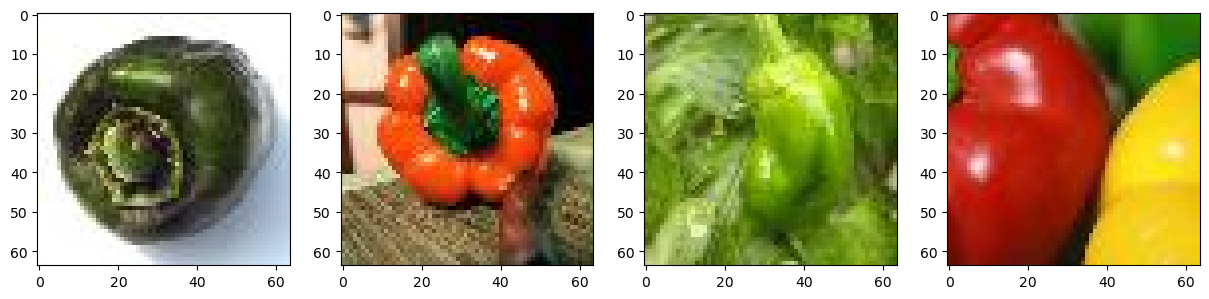

In [6]:
test_meta, test_images = load_images(False)

display(test_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(test_images[0]);
ax[1].imshow(test_images[1]);
ax[2].imshow(test_images[2]);
ax[3].imshow(test_images[3]);


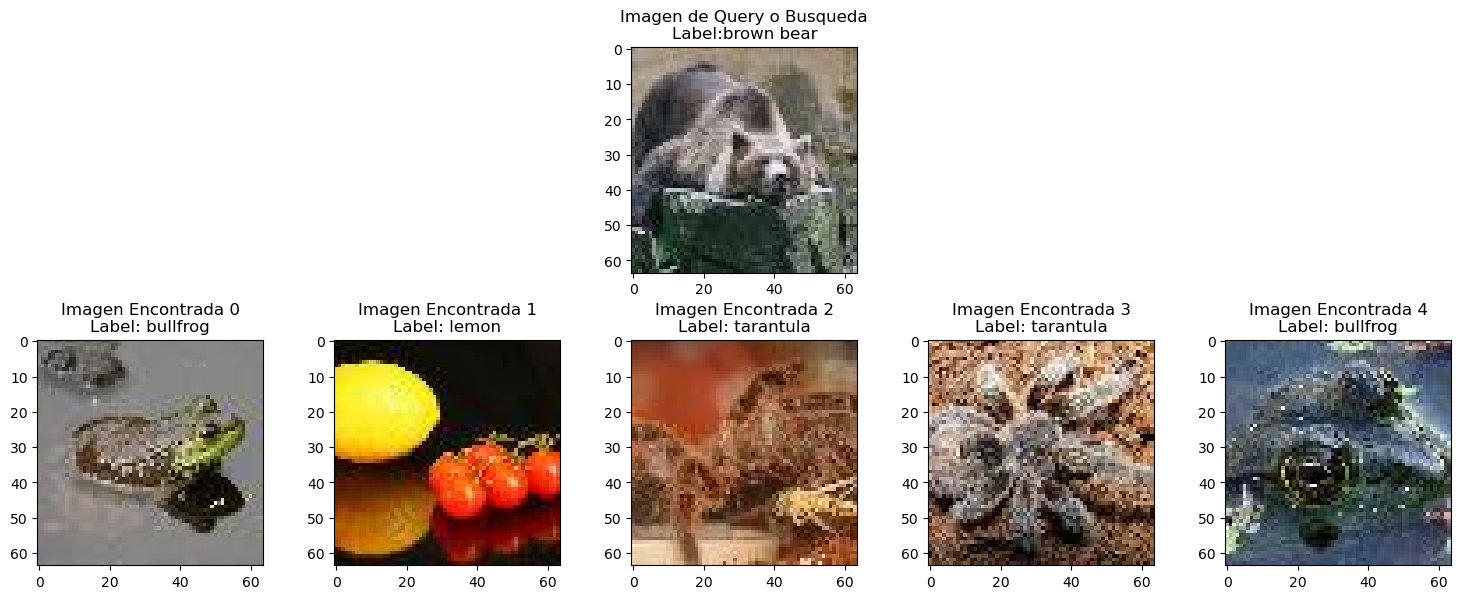

In [7]:
test_img = 50
img = test_images[test_img]
descs = orb_descriptor(img)
ret_idx = minmin_retrival(descs, descriptors, desc_meta, best_k=5, distance_function=cv2.NORM_HAMMING)

fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(ret_idx[:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


In [8]:
test_decs, test_desc_meta = extract_features(orb_descriptor, test_images, progress=True)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

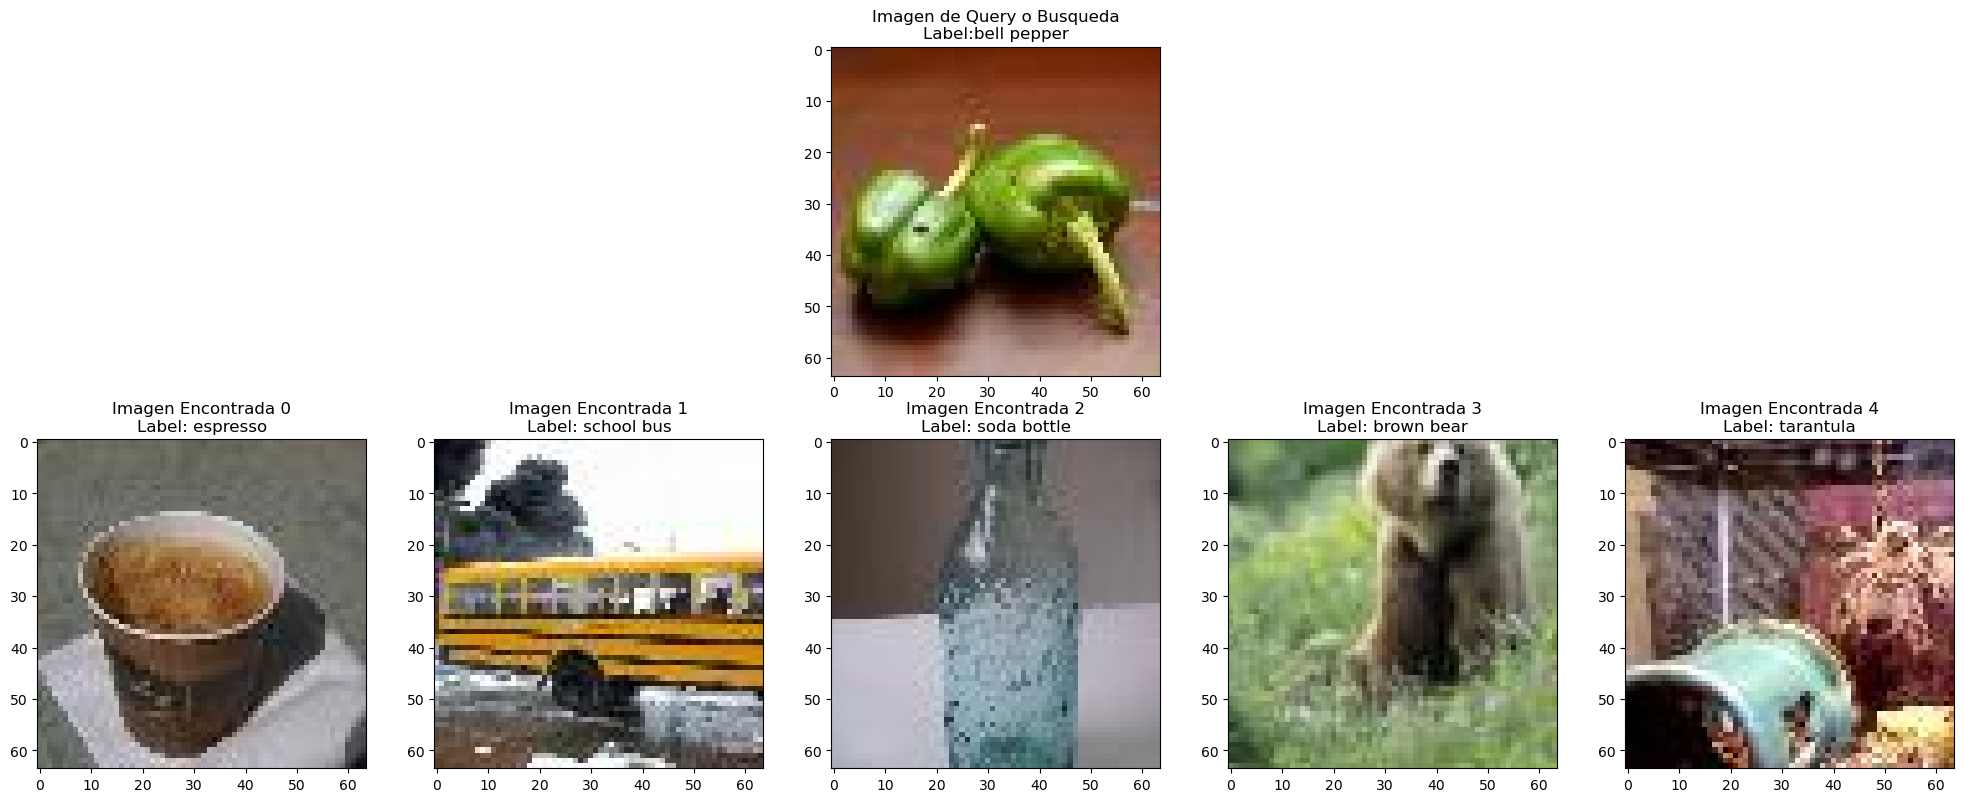

In [9]:
test_decs, test_desc_meta = extract_features(orb_descriptor, test_images, progress=True)

xr = match_all_images(test_decs, test_desc_meta, descriptors, desc_meta, best_k=50, distance_function=cv2.NORM_HAMMING)
fig, ax = plt.subplots(2, 5,  figsize = (20, 8))

test_img = 10
ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(xr[test_img][:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


In [10]:
calculate_metrics(xr, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

,Precision@K,Recall@K,R-Precision@K
K,,,
1,0.135593,0.001937,0.135593
5,0.166102,0.011864,0.166102
10,0.145763,0.020823,0.145763
25,0.141017,0.050363,0.141017
50,0.126780,0.090557,0.126780


In [42]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
    #descriptors, index = extract_features(cch_descriptor, images, progress = True)
K = 10
def convert_word(words, total_words):
    vocab = np.bincount(words, minlength=total_words)
    return normalize(vocab.reshape((1, -1)) ).reshape((-1))

def create_vocab(descriptors, index, vocab_model):
    k_bins = vocab_model.n_clusters
    idxs = {}
    for i, item in enumerate(index):
        if item not in idxs: idxs[item] = []
        idxs[item].append(i)

    pairs = {}
    print(k_bins)
    for image_id, idx in idxs.items():
        vocab = vocab_model.predict(descriptors[idx])
        pairs[image_id] = convert_word(vocab, k_bins)

    vocabulary = pd.DataFrame.from_dict(pairs, orient = 'index')

    return vocabulary



In [43]:
from tqdm import tqdm
scores1 = []
scores5 = []
scores10 = []
scores25 = []
scores50 = []

scores = []

image_meta, train_images = load_images(True) # True - Train Images
for K in tqdm(range(10, 40, 10)):
    orb_descriptor_func = partial(orb_descriptor, wta = 4) 
    train_desc, train_index = extract_features(orb_descriptor_func, train_images, min_features=1, progress = False)
    
    vocab_model = KMeans(n_clusters=K, n_init = 'auto', init = 'k-means++', random_state = 101010).fit(train_desc)
    
    td = create_vocab(train_desc, train_index, vocab_model)

    train_desc = td.values.astype(np.float32)
    train_index = list(td.index)

    test_desc , test_index  = extract_features(orb_descriptor_func, test_images)
    td = create_vocab(test_desc, test_index, vocab_model)
    test_desc = td.values.astype(np.float32)
    test_index = list(td.index)

    results = match_all_images(test_desc, test_index, train_desc, train_index, best_k=50, distance_function=cv2.NORM_L2)
    rprecision = calculate_metrics(results, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

    scores.append(rprecision)



  0%|          | 0/3 [00:00<?, ?it/s]c:\Users\ruben\anaconda3\envs\min-data\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
 33%|███▎      | 1/3 [00:00<00:00,  2.75it/s]

10
10


c:\Users\ruben\anaconda3\envs\min-data\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


20
20


 67%|██████▋   | 2/3 [00:00<00:00,  2.54it/s]c:\Users\ruben\anaconda3\envs\min-data\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


30
30


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


In [40]:
vocab_model

KMeans(n_clusters=40, n_init='auto', random_state=101010)